## Initial exploratory analysis and generation of a baseline model

### 1) Data cleaning and pre-processing

In [3]:
# import packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
import gc

In [4]:
# load data (train.csv will be the complete dataset for predictive modeling, ignore Test.csv for now)
data=pd.read_csv("./data/Train.csv")

In [5]:
# print the first five observations
data.head()

ID location                                               temp  \
0     ID_train_0        C  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1     ID_train_1        D  22.53333333,21.71666667,20.83333333,20.9833333...   
2    ID_train_10        A  28.975,27.95,29.6,26.425,22.09166667,21.775,22...   
3   ID_train_100        A  22.96666667,24.26666667,25.275,25.625,25.86666...   
4  ID_train_1000        A  21.875,21.575,21.525,21.43333333,20.50833333,1...   

                                              precip  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...   
2  0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...   
3  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...   
4  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....   

                                        rel_humidity  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  0.744583333,0.808083333,0.911166667,0.91633333...   
2  0.573333333,0.597166667,0.5668333329999999,0.6...   
3  0.8430833329999999,0.79025,0.7375,0.728,0.7049...   
4  0.8564166670000001,0.874916667,0.879833333,0.8...   

                                            wind_dir  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  281.6643101,89.15629262,81.96853891,291.018632...   
2  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
3  300.0850574,293.6769595,294.5174647,301.921416...   
4  21.83997432,17.05405341,89.26406044,123.585424...   

                                            wind_spd  \
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
1  2.3775,1.126666667,0.700833333,0.3416666670000...   
2  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   
3  1.446666667,1.1925,1.324166667,1.5441666669999...   
4  0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...   

                                         atmos_press      target  
0  nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...   45.126304  
1  90.32,90.3775,90.44083333,90.4725,90.45416667,...   79.131702  
2  88.55166667,88.46416667,88.31916667,88.24,88.2...   32.661304  
3  88.615,88.53083333,88.4,88.27166667,88.2075,88...   53.850238  
4  88.55666667,88.64083333,88.65833333,88.6475,88...  177.418750

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15539 entries, 0 to 15538
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            15539 non-null  object 
 1   location      15539 non-null  object 
 2   temp          15539 non-null  object 
 3   precip        15539 non-null  object 
 4   rel_humidity  15539 non-null  object 
 5   wind_dir      15539 non-null  object 
 6   wind_spd      15539 non-null  object 
 7   atmos_press   15539 non-null  object 
 8   target        15539 non-null  float64
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


A quick examination shows that the dataset contains an ID column, a location column indicating the sensor location, 6 feature variables containing sensor data to be used for target prediction, as well as the target itself.

The 6 feature variables are: temperature, precipitation, relative humidity, wind direction, wind speed, atmospheric pressure

For each observation, the data for the feature variables reflects the raw sensor measurements collected hourly over a 5-day period. These measurement periods are stored as a string per observation / feature. They thus need to be unpacked into list. As can be seen from the data table, each observation period contains varying degrees of missings (NaN), which need to be managed in a proper way. These missings occur either in the form of 'nan' or spaces in the string.
Also, it would be good to extract summary statistics from the different features for each recording period (e.g. mean, standard deviation, minimum, maximum) in order to engineer new features for the prediction.

The target represents the amount of PM2.5 particles in ug/m^3 measured exactly 24h after the end of the recording period for the feature measurements.

#### Convert the sensor data for each feature from string type into a list of values

In [7]:
# define a function to replace spaces in the string (i.e. missings) with NaN
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)

# define list of feature names
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]


for feature in features : 
    # first replace every 'nan' in a cell with an empty space, split using comma, and then apply replace_nan function on every item
    data[feature]=data[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])    

In [8]:
data.head()

ID location                                               temp  \
0     ID_train_0        C  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1     ID_train_1        D  [22.53333333, 21.71666667, 20.83333333, 20.983...   
2    ID_train_10        A  [28.975, 27.95, 29.6, 26.425, 22.09166667, 21....   
3   ID_train_100        A  [22.96666667, 24.26666667, 25.275, 25.625, 25....   
4  ID_train_1000        A  [21.875, 21.575, 21.525, 21.43333333, 20.50833...   

                                              precip  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...   
2  [0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        rel_humidity  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [0.744583333, 0.808083333, 0.911166667, 0.9163...   
2  [0.573333333, 0.597166667, 0.5668333329999999,...   
3  [0.8430833329999999, 0.79025, 0.7375, 0.728, 0...   
4  [0.8564166670000001, 0.874916667, 0.879833333,...   

                                            wind_dir  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [281.6643101, 89.15629262, 81.96853891, 291.01...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [300.0850574, 293.6769595, 294.5174647, 301.92...   
4  [21.83997432, 17.05405341, 89.26406044, 123.58...   

                                            wind_spd  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [2.3775, 1.126666667, 0.700833333, 0.341666667...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [1.446666667, 1.1925, 1.324166667, 1.544166666...   
4  [0.1975, 0.244166667, 0.411666667, 0.56, 0.577...   

                                         atmos_press      target  
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   45.126304  
1  [90.32, 90.3775, 90.44083333, 90.4725, 90.4541...   79.131702  
2  [88.55166667, 88.46416667, 88.31916667, 88.24,...   32.661304  
3  [88.615, 88.53083333, 88.4, 88.27166667, 88.20...   53.850238  
4  [88.55666667, 88.64083333, 88.65833333, 88.647...  177.418750

Thus, for every observation, each feature value is represented as a list of raw values over an hourly 5-day recording period

### Features engineering part

#### Extract summary statistics per observation period for every feature

In [9]:
df_temp = data[['location', 'temp']]
df_temp.head()

location                                               temp
0        C  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
1        D  [22.53333333, 21.71666667, 20.83333333, 20.983...
2        A  [28.975, 27.95, 29.6, 26.425, 22.09166667, 21....
3        A  [22.96666667, 24.26666667, 25.275, 25.625, 25....
4        A  [21.875, 21.575, 21.525, 21.43333333, 20.50833...

In [10]:
df_temp['percent_nan'] = data.temp.apply(lambda x: np.isnan(np.array(x)).sum()/len(x)*100)

/var/folders/jy/dzvsvxv95gggzwht8xmx88yh0000gn/T/ipykernel_9656/191758199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['percent_nan'] = data.temp.apply(lambda x: np.isnan(np.array(x)).sum()/len(x)*100)


In [11]:
df_temp.head()

location                                               temp  percent_nan
0        C  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...    86.776860
1        D  [22.53333333, 21.71666667, 20.83333333, 20.983...     0.000000
2        A  [28.975, 27.95, 29.6, 26.425, 22.09166667, 21....     0.826446
3        A  [22.96666667, 24.26666667, 25.275, 25.625, 25....     0.000000
4        A  [21.875, 21.575, 21.525, 21.43333333, 20.50833...    75.206612

In [12]:
# recording periods contain varying degrees of NaNs: compute percent NaN for each recording period and feature
# function to compute the percentage of NaNs per recording period
def compute_percent_nan(df, col_name):
    df['percent_nan_'+col_name] = df[col_name].apply(lambda x: np.isnan(np.array(x)).sum()/len(x)*100)
    return df

In [13]:
# calculate percentage of missings per recording period and feature and append to dataframe
for col_name in tqdm(features):
    data=compute_percent_nan(data,col_name)

100%|██████████| 6/6 [00:00<00:00, 11.18it/s]


In [14]:
data.head()

ID location                                               temp  \
0     ID_train_0        C  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1     ID_train_1        D  [22.53333333, 21.71666667, 20.83333333, 20.983...   
2    ID_train_10        A  [28.975, 27.95, 29.6, 26.425, 22.09166667, 21....   
3   ID_train_100        A  [22.96666667, 24.26666667, 25.275, 25.625, 25....   
4  ID_train_1000        A  [21.875, 21.575, 21.525, 21.43333333, 20.50833...   

                                              precip  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...   
2  [0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        rel_humidity  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [0.744583333, 0.808083333, 0.911166667, 0.9163...   
2  [0.573333333, 0.597166667, 0.5668333329999999,...   
3  [0.8430833329999999, 0.79025, 0.7375, 0.728, 0...   
4  [0.8564166670000001, 0.874916667, 0.879833333,...   

                                            wind_dir  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [281.6643101, 89.15629262, 81.96853891, 291.01...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [300.0850574, 293.6769595, 294.5174647, 301.92...   
4  [21.83997432, 17.05405341, 89.26406044, 123.58...   

                                            wind_spd  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
1  [2.3775, 1.126666667, 0.700833333, 0.341666667...   
2  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
3  [1.446666667, 1.1925, 1.324166667, 1.544166666...   
4  [0.1975, 0.244166667, 0.411666667, 0.56, 0.577...   

                                         atmos_press      target  \
0  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   45.126304   
1  [90.32, 90.3775, 90.44083333, 90.4725, 90.4541...   79.131702   
2  [88.55166667, 88.46416667, 88.31916667, 88.24,...   32.661304   
3  [88.615, 88.53083333, 88.4, 88.27166667, 88.20...   53.850238   
4  [88.55666667, 88.64083333, 88.65833333, 88.647...  177.418750   

   percent_nan_temp  percent_nan_precip  percent_nan_rel_humidity  \
0         86.776860           86.776860                 86.776860   
1          0.000000            0.000000                  0.000000   
2          0.826446            0.826446                  0.826446   
3          0.000000            0.000000                  0.000000   
4         75.206612           75.206612                 75.206612   

   percent_nan_wind_dir  percent_nan_wind_spd  percent_nan_atmos_press  
0             86.776860             86.776860                86.776860  
1              0.000000              0.000000                 0.000000  
2             38.016529             38.016529                 0.826446  
3             42.148760             42.148760                 0.000000  
4             75.206612             75.206612                75.206612

In [15]:
data.columns.tolist()

['ID',
 'location',
 'temp',
 'precip',
 'rel_humidity',
 'wind_dir',
 'wind_spd',
 'atmos_press',
 'target',
 'percent_nan_temp',
 'percent_nan_precip',
 'percent_nan_rel_humidity',
 'percent_nan_wind_dir',
 'percent_nan_wind_spd',
 'percent_nan_atmos_press']

In [16]:
# aggregation function extracting summary statistics from every recording period and appending it as a new column to a dataframe
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  

# function returning only non-Null values (helper for aggregation function)
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [17]:
# remove NaNs from dataframe
for col_name in tqdm(features):
   data[col_name]=data[col_name].apply(remove_nan_values)

100%|██████████| 6/6 [00:00<00:00,  8.71it/s]


In [18]:
data.head()

ID location                                               temp  \
0     ID_train_0        C  [26.90909091, 27.20833333, 26.18333333, 24.7, ...   
1     ID_train_1        D  [22.53333333, 21.71666667, 20.83333333, 20.983...   
2    ID_train_10        A  [28.975, 27.95, 29.6, 26.425, 22.09166667, 21....   
3   ID_train_100        A  [22.96666667, 24.26666667, 25.275, 25.625, 25....   
4  ID_train_1000        A  [21.875, 21.575, 21.525, 21.43333333, 20.50833...   

                                              precip  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...   
2  [0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        rel_humidity  \
0  [0.5108181820000001, 0.535416667, 0.6145, 0.63...   
1  [0.744583333, 0.808083333, 0.911166667, 0.9163...   
2  [0.573333333, 0.597166667, 0.5668333329999999,...   
3  [0.8430833329999999, 0.79025, 0.7375, 0.728, 0...   
4  [0.8564166670000001, 0.874916667, 0.879833333,...   

                                            wind_dir  \
0  [272.90275160000004, 104.565241, 167.1772247, ...   
1  [281.6643101, 89.15629262, 81.96853891, 291.01...   
2  [328.68291380000005, 307.8251459, 319.0177512,...   
3  [300.0850574, 293.6769595, 294.5174647, 301.92...   
4  [21.83997432, 17.05405341, 89.26406044, 123.58...   

                                            wind_spd  \
0  [0.800909091, 1.073333333, 1.5175, 1.4625, 0.5...   
1  [2.3775, 1.126666667, 0.700833333, 0.341666667...   
2  [1.0325, 1.193333333, 1.275833333, 1.493333333...   
3  [1.446666667, 1.1925, 1.324166667, 1.544166666...   
4  [0.1975, 0.244166667, 0.411666667, 0.56, 0.577...   

                                         atmos_press      target  \
0  [87.77727273, 87.6525, 87.61416667, 87.6375, 8...   45.126304   
1  [90.32, 90.3775, 90.44083333, 90.4725, 90.4541...   79.131702   
2  [88.55166667, 88.46416667, 88.31916667, 88.24,...   32.661304   
3  [88.615, 88.53083333, 88.4, 88.27166667, 88.20...   53.850238   
4  [88.55666667, 88.64083333, 88.65833333, 88.647...  177.418750   

   percent_nan_temp  percent_nan_precip  percent_nan_rel_humidity  \
0         86.776860           86.776860                 86.776860   
1          0.000000            0.000000                  0.000000   
2          0.826446            0.826446                  0.826446   
3          0.000000            0.000000                  0.000000   
4         75.206612           75.206612                 75.206612   

   percent_nan_wind_dir  percent_nan_wind_spd  percent_nan_atmos_press  
0             86.776860             86.776860                86.776860  
1              0.000000              0.000000                 0.000000  
2             38.016529             38.016529                 0.826446  
3             42.148760             42.148760                 0.000000  
4             75.206612             75.206612                75.206612

In [19]:
#extract summary statistics for each recording period and feature
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


In [20]:
data.head()

ID location                                               temp  \
0     ID_train_0        C  [26.90909091, 27.20833333, 26.18333333, 24.7, ...   
1     ID_train_1        D  [22.53333333, 21.71666667, 20.83333333, 20.983...   
2    ID_train_10        A  [28.975, 27.95, 29.6, 26.425, 22.09166667, 21....   
3   ID_train_100        A  [22.96666667, 24.26666667, 25.275, 25.625, 25....   
4  ID_train_1000        A  [21.875, 21.575, 21.525, 21.43333333, 20.50833...   

                                              precip  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0...   
2  [0.0, 0.0, 0.0, 0.102, 0.136, 0.0, 0.0, 2.16, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.77,...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        rel_humidity  \
0  [0.5108181820000001, 0.535416667, 0.6145, 0.63...   
1  [0.744583333, 0.808083333, 0.911166667, 0.9163...   
2  [0.573333333, 0.597166667, 0.5668333329999999,...   
3  [0.8430833329999999, 0.79025, 0.7375, 0.728, 0...   
4  [0.8564166670000001, 0.874916667, 0.879833333,...   

                                            wind_dir  \
0  [272.90275160000004, 104.565241, 167.1772247, ...   
1  [281.6643101, 89.15629262, 81.96853891, 291.01...   
2  [328.68291380000005, 307.8251459, 319.0177512,...   
3  [300.0850574, 293.6769595, 294.5174647, 301.92...   
4  [21.83997432, 17.05405341, 89.26406044, 123.58...   

                                            wind_spd  \
0  [0.800909091, 1.073333333, 1.5175, 1.4625, 0.5...   
1  [2.3775, 1.126666667, 0.700833333, 0.341666667...   
2  [1.0325, 1.193333333, 1.275833333, 1.493333333...   
3  [1.446666667, 1.1925, 1.324166667, 1.544166666...   
4  [0.1975, 0.244166667, 0.411666667, 0.56, 0.577...   

                                         atmos_press      target  \
0  [87.77727273, 87.6525, 87.61416667, 87.6375, 8...   45.126304   
1  [90.32, 90.3775, 90.44083333, 90.4725, 90.4541...   79.131702   
2  [88.55166667, 88.46416667, 88.31916667, 88.24,...   32.661304   
3  [88.615, 88.53083333, 88.4, 88.27166667, 88.20...   53.850238   
4  [88.55666667, 88.64083333, 88.65833333, 88.647...  177.418750   

   percent_nan_temp  ...  var_wind_spd  median_wind_spd  ptp_wind_spd  \
0         86.776860  ...      0.155268         0.666250      1.355000   
1          0.000000  ...      0.290736         0.744167      2.760833   
2          0.826446  ...      0.342484         0.942500      2.420000   
3          0.000000  ...      0.336701         1.388333      2.469167   
4         75.206612  ...      0.181690         0.542917      1.796667   

   max_atmos_press  min_atmos_press  mean_atmos_press  std_atmos_press  \
0        87.871667        87.614167         87.752434         0.070374   
1        90.725000        90.056667         90.429924         0.156000   
2        88.813333        87.982500         88.420931         0.179481   
3        88.685000        87.965000         88.376915         0.161758   
4        88.719167        88.268333         88.538104         0.118369   

   var_atmos_press  median_atmos_press  ptp_atmos_press  
0         0.004952           87.762083         0.257500  
1         0.024336           90.429167         0.668333  
2         0.032213           88.425000         0.830833  
3         0.026166           88.400000         0.720000  
4         0.014011           88.552500         0.450833  

[5 rows x 57 columns]

In [21]:
# extract all single raw values from each feature and append them as new columns to the dataframe
for x in range(121):
    data["newtemp"+ str(x)] = data.temp.str[x]
    data["newprecip"+ str(x)] = data.precip.str[x]
    data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atmospherepressure"+ str(x)] = data.atmos_press.str[x]

/var/folders/jy/dzvsvxv95gggzwht8xmx88yh0000gn/T/ipykernel_9656/268327596.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["newrel_humidity"+ str(x)] = data.rel_humidity.str[x]
/var/folders/jy/dzvsvxv95gggzwht8xmx88yh0000gn/T/ipykernel_9656/268327596.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data["newwind_dir"+ str(x)] = data.wind_dir.str[x]
/var/folders/jy/dzvsvxv95gggzwht8xmx88yh0000gn/T/ipykernel_9656/268327596.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

In [22]:
# drop raw sensor data contained as list from the initial dataset
data.drop(features,1,inplace=True)

/var/folders/jy/dzvsvxv95gggzwht8xmx88yh0000gn/T/ipykernel_9656/1401606462.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(features,1,inplace=True)


In [23]:
data.head()

ID location      target  percent_nan_temp  percent_nan_precip  \
0     ID_train_0        C   45.126304         86.776860           86.776860   
1     ID_train_1        D   79.131702          0.000000            0.000000   
2    ID_train_10        A   32.661304          0.826446            0.826446   
3   ID_train_100        A   53.850238          0.000000            0.000000   
4  ID_train_1000        A  177.418750         75.206612           75.206612   

   percent_nan_rel_humidity  percent_nan_wind_dir  percent_nan_wind_spd  \
0                 86.776860             86.776860             86.776860   
1                  0.000000              0.000000              0.000000   
2                  0.826446             38.016529             38.016529   
3                  0.000000             42.148760             42.148760   
4                 75.206612             75.206612             75.206612   

   percent_nan_atmos_press   max_temp  ...  newrel_humidity119  \
0                86.776860  27.208333  ...                 NaN   
1                 0.000000  33.616667  ...            0.649250   
2                 0.826446  31.841667  ...            0.437917   
3                 0.000000  27.491667  ...            0.766417   
4                75.206612  28.750000  ...                 NaN   

   newwind_dir119  windspeed119  atmospherepressure119  newtemp120  \
0             NaN           NaN                    NaN         NaN   
1       73.528733      1.475833              90.439167   21.450000   
2             NaN           NaN              88.415833         NaN   
3             NaN           NaN              88.490833   24.641667   
4             NaN           NaN                    NaN         NaN   

   newprecip120  newrel_humidity120  newwind_dir120  windspeed120  \
0           NaN                 NaN             NaN           NaN   
1         0.561            0.797333      296.967254      1.019167   
2           NaN                 NaN             NaN           NaN   
3         0.000            0.719667             NaN           NaN   
4           NaN                 NaN             NaN           NaN   

   atmospherepressure120  
0                    NaN  
1              90.529167  
2                    NaN  
3              88.465833  
4                    NaN  

[5 rows x 777 columns]

### Exploratory data analysis

In [24]:
# list dataframe columns for target and condensed features, including percent NaNs
summary_columns = data.columns[:51]
summary_columns

Index(['ID', 'location', 'target', 'percent_nan_temp', 'percent_nan_precip',
       'percent_nan_rel_humidity', 'percent_nan_wind_dir',
       'percent_nan_wind_spd', 'percent_nan_atmos_press', 'max_temp',
       'min_temp', 'mean_temp', 'std_temp', 'var_temp', 'median_temp',
       'ptp_temp', 'max_precip', 'min_precip', 'mean_precip', 'std_precip',
       'var_precip', 'median_precip', 'ptp_precip', 'max_rel_humidity',
       'min_rel_humidity', 'mean_rel_humidity', 'std_rel_humidity',
       'var_rel_humidity', 'median_rel_humidity', 'ptp_rel_humidity',
       'max_wind_dir', 'min_wind_dir', 'mean_wind_dir', 'std_wind_dir',
       'var_wind_dir', 'median_wind_dir', 'ptp_wind_dir', 'max_wind_spd',
       'min_wind_spd', 'mean_wind_spd', 'std_wind_spd', 'var_wind_spd',
       'median_wind_spd', 'ptp_wind_spd', 'max_atmos_press', 'min_atmos_press',
       'mean_atmos_press', 'std_atmos_press', 'var_atmos_press',
       'median_atmos_press', 'ptp_atmos_press'],
      dtype='object')

In [25]:
# select data with summary statistics for the different features
df_condensed = data[summary_columns]
df_condensed.set_index('ID', drop=True, inplace=True)
df_condensed.head()

location      target  percent_nan_temp  percent_nan_precip  \
ID                                                                         
ID_train_0           C   45.126304         86.776860           86.776860   
ID_train_1           D   79.131702          0.000000            0.000000   
ID_train_10          A   32.661304          0.826446            0.826446   
ID_train_100         A   53.850238          0.000000            0.000000   
ID_train_1000        A  177.418750         75.206612           75.206612   

               percent_nan_rel_humidity  percent_nan_wind_dir  \
ID                                                              
ID_train_0                    86.776860             86.776860   
ID_train_1                     0.000000              0.000000   
ID_train_10                    0.826446             38.016529   
ID_train_100                   0.000000             42.148760   
ID_train_1000                 75.206612             75.206612   

               percent_nan_wind_spd  percent_nan_atmos_press   max_temp  \
ID                                                                        
ID_train_0                86.776860                86.776860  27.208333   
ID_train_1                 0.000000                 0.000000  33.616667   
ID_train_10               38.016529                 0.826446  31.841667   
ID_train_100              42.148760                 0.000000  27.491667   
ID_train_1000             75.206612                75.206612  28.750000   

                min_temp  ...  var_wind_spd  median_wind_spd  ptp_wind_spd  \
ID                        ...                                                
ID_train_0     19.275000  ...      0.155268         0.666250      1.355000   
ID_train_1     17.983333  ...      0.290736         0.744167      2.760833   
ID_train_10    18.458333  ...      0.342484         0.942500      2.420000   
ID_train_100   16.941667  ...      0.336701         1.388333      2.469167   
ID_train_1000  17.525000  ...      0.181690         0.542917      1.796667   

               max_atmos_press  min_atmos_press  mean_atmos_press  \
ID                                                                  
ID_train_0           87.871667        87.614167         87.752434   
ID_train_1           90.725000        90.056667         90.429924   
ID_train_10          88.813333        87.982500         88.420931   
ID_train_100         88.685000        87.965000         88.376915   
ID_train_1000        88.719167        88.268333         88.538104   

               std_atmos_press  var_atmos_press  median_atmos_press  \
ID                                                                    
ID_train_0            0.070374         0.004952           87.762083   
ID_train_1            0.156000         0.024336           90.429167   
ID_train_10           0.179481         0.032213           88.425000   
ID_train_100          0.161758         0.026166           88.400000   
ID_train_1000         0.118369         0.014011           88.552500   

               ptp_atmos_press  
ID                              
ID_train_0            0.257500  
ID_train_1            0.668333  
ID_train_10           0.830833  
ID_train_100          0.720000  
ID_train_1000         0.450833  

[5 rows x 50 columns]

### Compute basic summary statistics

In [26]:
df_condensed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15539 entries, ID_train_0 to ID_train_9999
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   location                  15539 non-null  object 
 1   target                    15539 non-null  float64
 2   percent_nan_temp          15539 non-null  float64
 3   percent_nan_precip        15539 non-null  float64
 4   percent_nan_rel_humidity  15539 non-null  float64
 5   percent_nan_wind_dir      15539 non-null  float64
 6   percent_nan_wind_spd      15539 non-null  float64
 7   percent_nan_atmos_press   15539 non-null  float64
 8   max_temp                  15539 non-null  float64
 9   min_temp                  15539 non-null  float64
 10  mean_temp                 15539 non-null  float64
 11  std_temp                  15539 non-null  float64
 12  var_temp                  15539 non-null  float64
 13  median_temp               15539 non-null  float64

In [27]:
# get descriptive statistics on the percentage of NaNs for the recording period
df_condensed[['percent_nan_temp', 'percent_nan_precip',
       'percent_nan_rel_humidity', 'percent_nan_wind_dir',
       'percent_nan_wind_spd', 'percent_nan_atmos_press']].describe().round(2)

percent_nan_temp  percent_nan_precip  percent_nan_rel_humidity  \
count          15539.00            15539.00                  15539.00   
mean               6.34                6.32                      6.28   
std               17.40               17.61                     17.33   
min                0.00                0.00                      0.00   
25%                0.00                0.00                      0.00   
50%                0.00                0.00                      0.00   
75%                0.00                0.00                      0.83   
max               89.26               89.26                     89.26   

       percent_nan_wind_dir  percent_nan_wind_spd  percent_nan_atmos_press  
count              15539.00              15539.00                 15539.00  
mean                  10.37                 10.37                     6.10  
std                   19.51                 19.51                    17.32  
min                    0.00                  0.00                     0.00  
25%                    0.00                  0.00                     0.00  
50%                    0.00                  0.00                     0.00  
75%                   11.57                 11.57                     0.00  
max                   89.26                 89.26                    89.26

### Distribution and correlations of percent NaNs between features

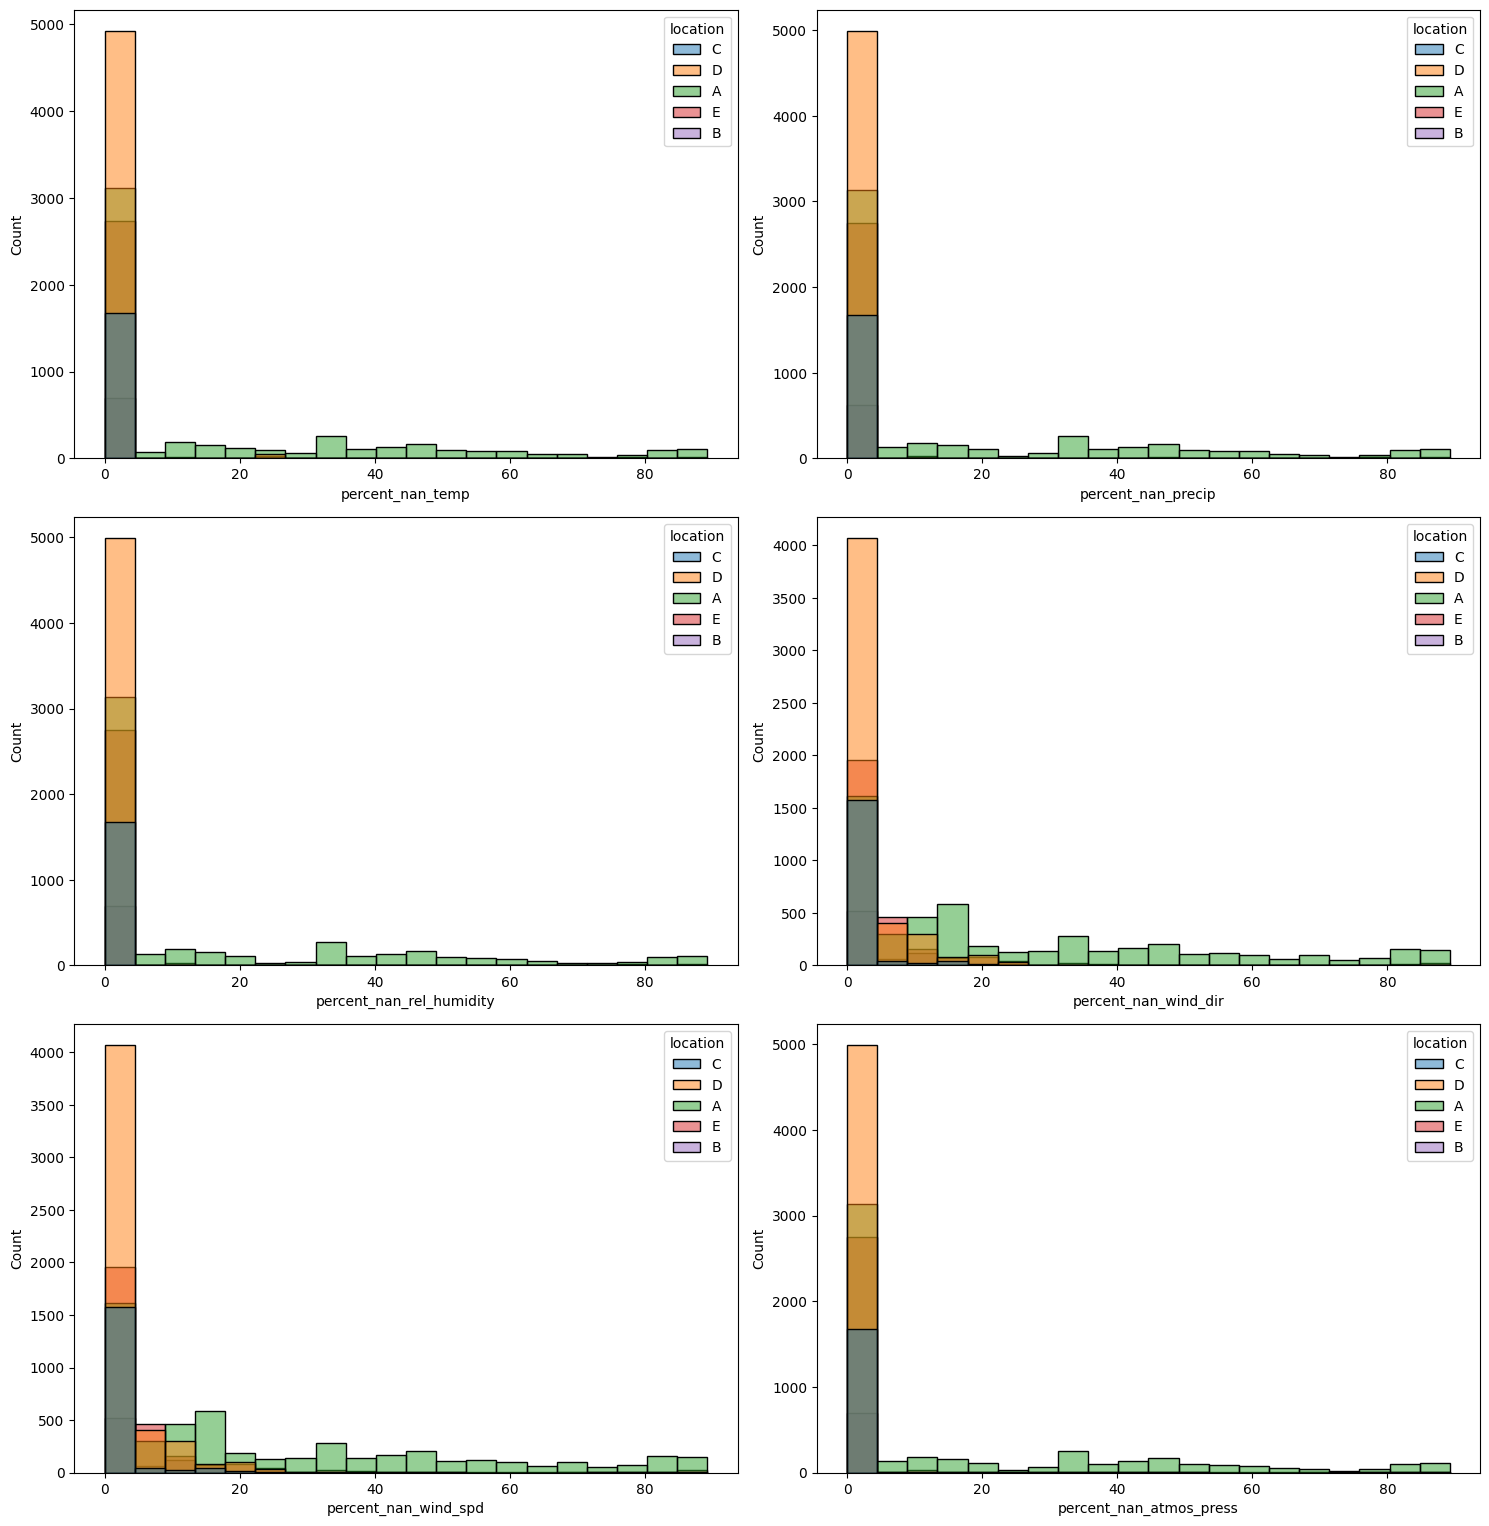

In [28]:
# check the overall distribution of percent NaNs depending on sensor location using histograms

nan_columns = ['percent_nan_temp', 'percent_nan_precip','percent_nan_rel_humidity', 'percent_nan_wind_dir','percent_nan_wind_spd', 
        'percent_nan_atmos_press']

fig = plt.figure(figsize=(15, 20))

for i in range(1, len(nan_columns)+1): # start with i=1 (0th subplot is not possible)
    ax = fig.add_subplot(4, 2, i) # arrange figure as rows = 6 x cols = 4 panel and add ith subplot
    subplot = sns.histplot(x=nan_columns[i-1], hue='location', bins=20, data=df_condensed)
    ax.set_xlabel(nan_columns[i-1])

fig.tight_layout() # prevents subplots from overlapping

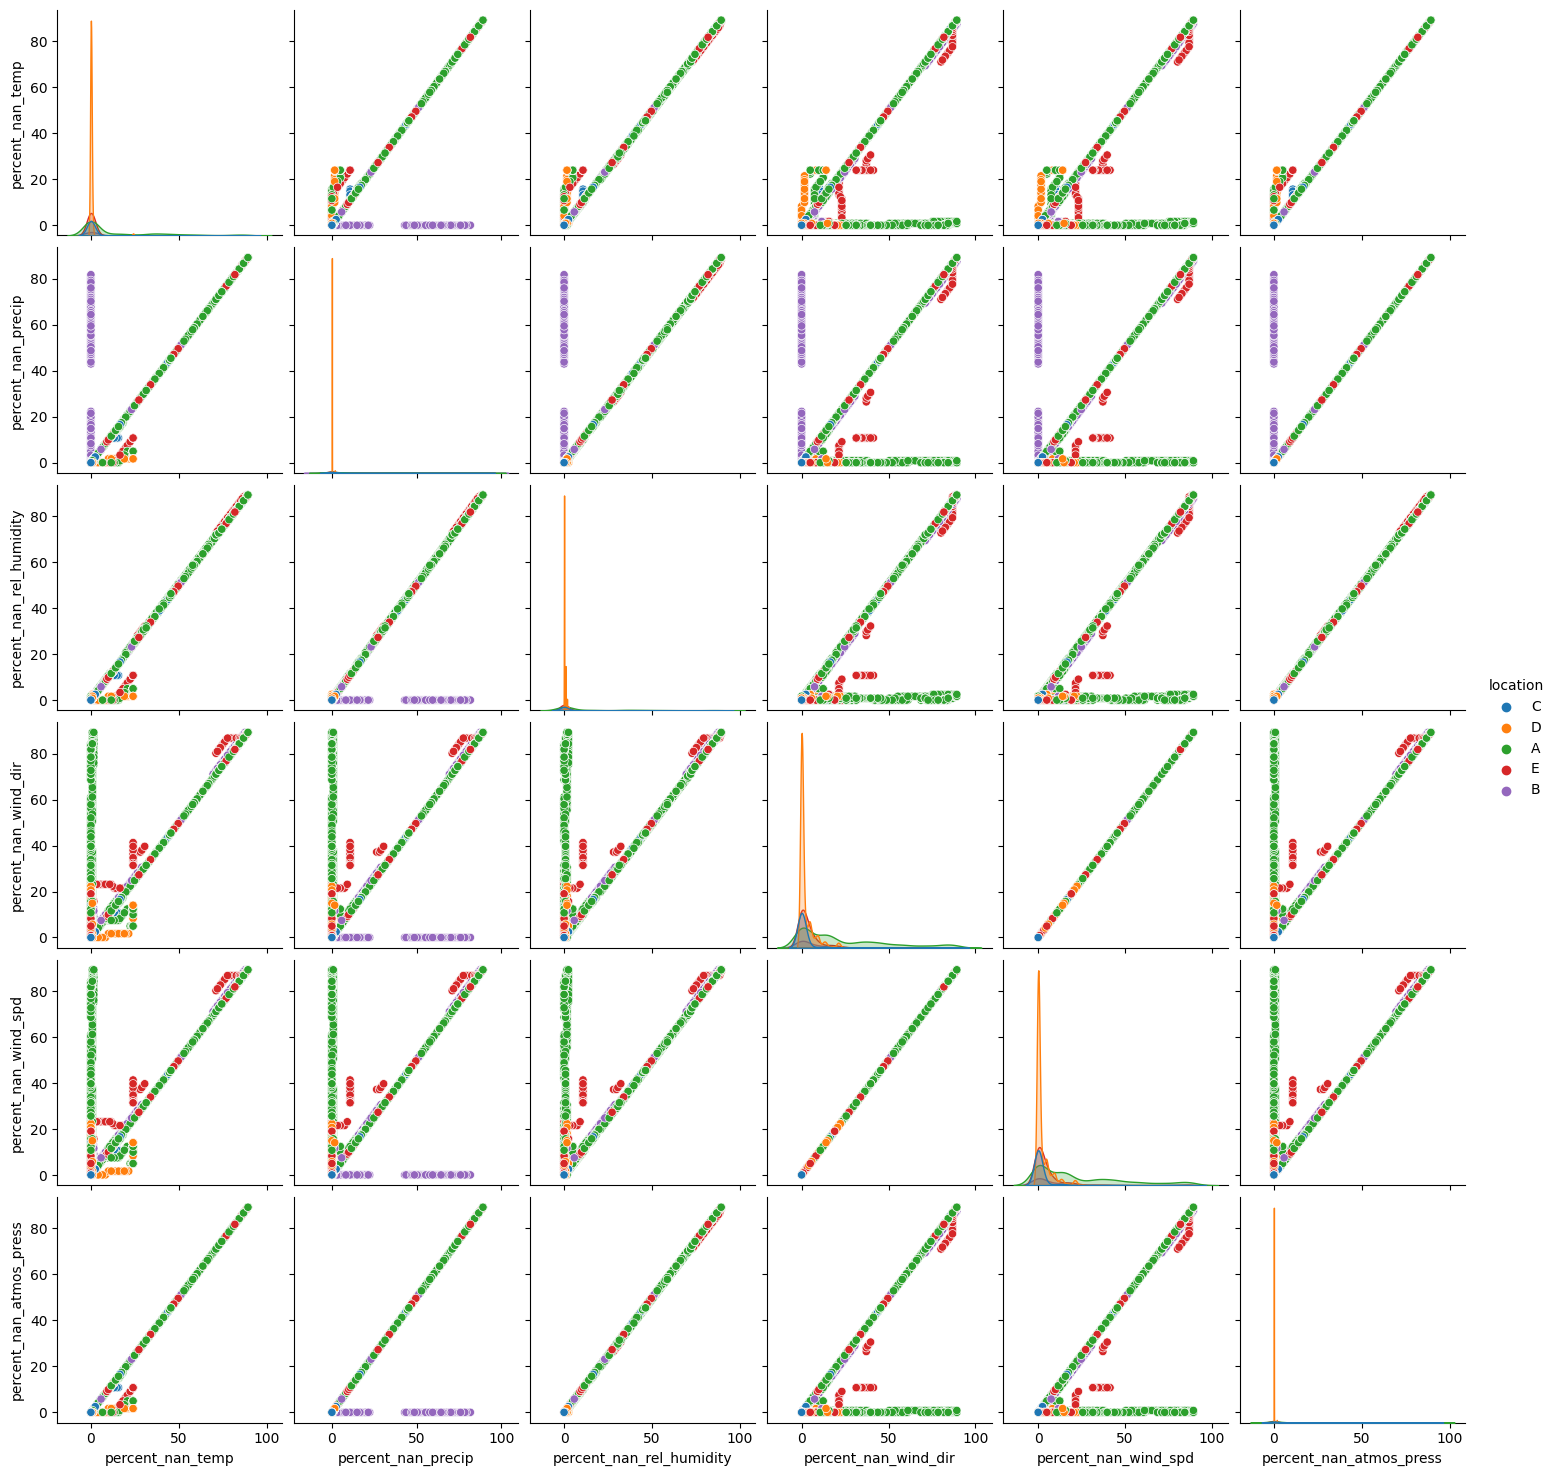

In [29]:
# plot pairplot to examine feature-wise correlations in the percent NaNs
sns.pairplot(df_condensed[['location', 'percent_nan_temp', 'percent_nan_precip','percent_nan_rel_humidity', 'percent_nan_wind_dir','percent_nan_wind_spd', 
        'percent_nan_atmos_press']], hue='location');

### Filter dataframe for observations with percent NaN < 30% for all features

In [30]:
# filter observations based on percent NaN and check again the data distribution of the target and summary features
df_filtered = df_condensed[(df_condensed[nan_columns]<30).all(axis=1)]
df_filtered.head()

location     target  percent_nan_temp  percent_nan_precip  \
ID                                                                         
ID_train_1            D  79.131702               0.0                 0.0   
ID_train_10000        E  17.005000               0.0                 0.0   
ID_train_10001        C  53.100000               0.0                 0.0   
ID_train_10002        A  55.051143               0.0                 0.0   
ID_train_10005        D  55.638261               0.0                 0.0   

                percent_nan_rel_humidity  percent_nan_wind_dir  \
ID                                                               
ID_train_1                      0.000000              0.000000   
ID_train_10000                  0.000000             14.049587   
ID_train_10001                  0.000000              0.000000   
ID_train_10002                  0.000000              3.305785   
ID_train_10005                  0.826446              1.652893   

                percent_nan_wind_spd  percent_nan_atmos_press   max_temp  \
ID                                                                         
ID_train_1                  0.000000                      0.0  33.616667   
ID_train_10000             14.049587                      0.0  28.416667   
ID_train_10001              0.000000                      0.0  29.266667   
ID_train_10002              3.305785                      0.0  29.483333   
ID_train_10005              1.652893                      0.0  34.041667   

                 min_temp  ...  var_wind_spd  median_wind_spd  ptp_wind_spd  \
ID                         ...                                                
ID_train_1      17.983333  ...      0.290736         0.744167      2.760833   
ID_train_10000  17.183333  ...      0.282313         1.075000      3.122500   
ID_train_10001  19.116667  ...      0.198869         0.893333      1.884167   
ID_train_10002  16.933333  ...      0.226285         0.716667      1.919167   
ID_train_10005  17.191667  ...      0.533776         0.840833      3.285000   

                max_atmos_press  min_atmos_press  mean_atmos_press  \
ID                                                                   
ID_train_1            90.725000        90.056667         90.429924   
ID_train_10000        88.746667        88.097500         88.437645   
ID_train_10001        87.961667        87.472500         87.717645   
ID_train_10002        88.511667        87.838333         88.212652   
ID_train_10005        90.986667        90.211667         90.624814   

                std_atmos_press  var_atmos_press  median_atmos_press  \
ID                                                                     
ID_train_1             0.156000         0.024336           90.429167   
ID_train_10000         0.147604         0.021787           88.420833   
ID_train_10001         0.121492         0.014760           87.729167   
ID_train_10002         0.169373         0.028687           88.235000   
ID_train_10005         0.179998         0.032399           90.641667   

                ptp_atmos_press  
ID                               
ID_train_1             0.668333  
ID_train_10000         0.649167  
ID_train_10001         0.489167  
ID_train_10002         0.673333  
ID_train_10005         0.775000  

[5 rows x 50 columns]

In [31]:
percent_reduc = (df_condensed.shape[0]-df_filtered.shape[0]) / df_condensed.shape[0]*100
print(f'Percent reduction in dataset size after filtering: {round(percent_reduc,1)}%')

Percent reduction in dataset size after filtering: 13.0%


### Data distribution for the summary features and target

In [32]:
# get target and summary feature columns
colnames = df_condensed.columns.to_list()[1::] # get columns w/o location column
del colnames[1:8] # delete columns containing data on percent NaN
colnames

['target',
 'min_temp',
 'mean_temp',
 'std_temp',
 'var_temp',
 'median_temp',
 'ptp_temp',
 'max_precip',
 'min_precip',
 'mean_precip',
 'std_precip',
 'var_precip',
 'median_precip',
 'ptp_precip',
 'max_rel_humidity',
 'min_rel_humidity',
 'mean_rel_humidity',
 'std_rel_humidity',
 'var_rel_humidity',
 'median_rel_humidity',
 'ptp_rel_humidity',
 'max_wind_dir',
 'min_wind_dir',
 'mean_wind_dir',
 'std_wind_dir',
 'var_wind_dir',
 'median_wind_dir',
 'ptp_wind_dir',
 'max_wind_spd',
 'min_wind_spd',
 'mean_wind_spd',
 'std_wind_spd',
 'var_wind_spd',
 'median_wind_spd',
 'ptp_wind_spd',
 'max_atmos_press',
 'min_atmos_press',
 'mean_atmos_press',
 'std_atmos_press',
 'var_atmos_press',
 'median_atmos_press',
 'ptp_atmos_press']

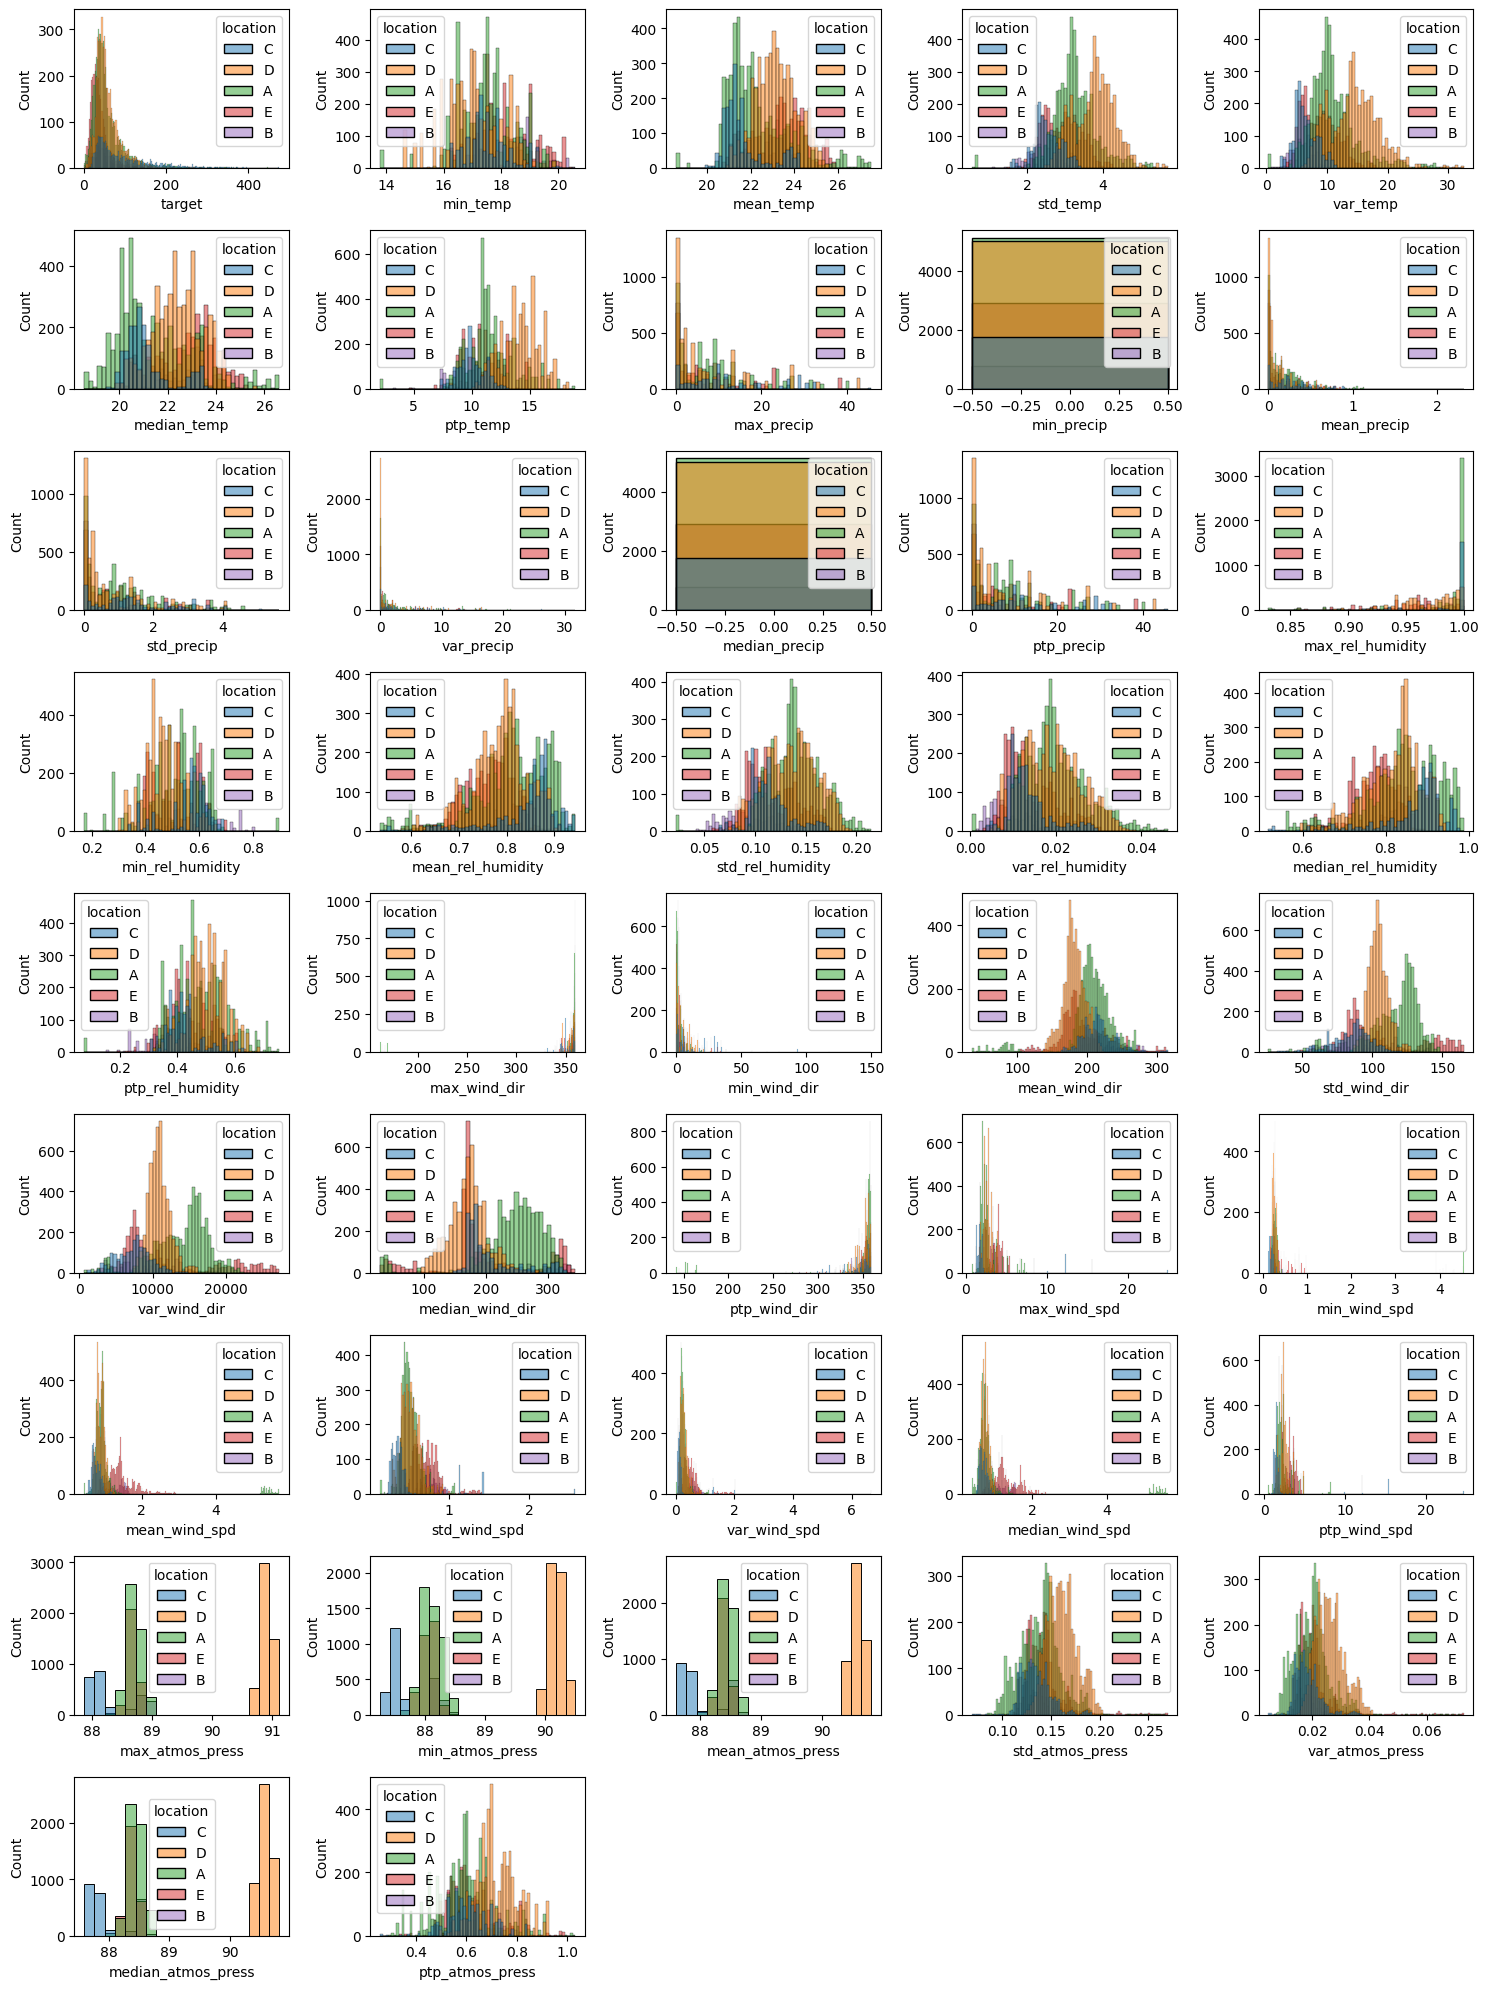

In [33]:
# plot histograms on the distribution of the other data
fig = plt.figure(figsize=(15, 20))

for i in range(1, len(colnames)+1): # start with i=1 (0th subplot is not possible)
    ax = fig.add_subplot(9, 5, i) # arrange figure as rows = 6 x cols = 4 panel and add ith subplot
    subplot = sns.histplot(x=colnames[i-1], hue='location', data=df_condensed)
    ax.set_xlabel(colnames[i-1])

fig.tight_layout() # prevents subplots from overlapping

### Mean differences in air pollution between locations for filtered and unfiltered data

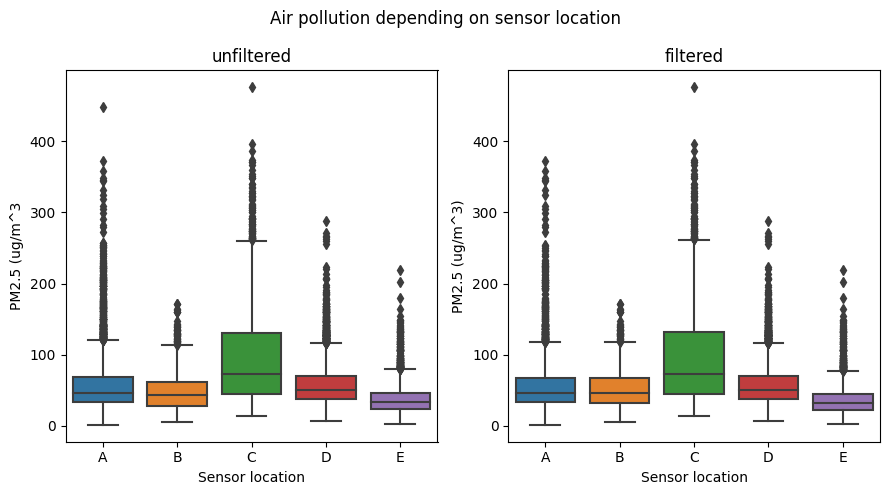

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Air pollution depending on sensor location')

plot1 = sns.boxplot(data=df_condensed, x='location', y='target', ax=ax1, order=['A', 'B', 'C', 'D', 'E'])
ax1.set_title('unfiltered')
ax1.set_ylabel('PM2.5 (ug/m^3')
ax1.set_xlabel('Sensor location')

plot2 = sns.boxplot(data=df_filtered, x='location', y='target', ax=ax2, order=['A', 'B', 'C', 'D', 'E'])
ax2.set_title('filtered')
ax2.set_ylabel('PM2.5 (ug/m^3)')
ax2.set_xlabel('Sensor location')

plt.tight_layout();

### Correlations between mean values for features and target for unfiltered and filtered data

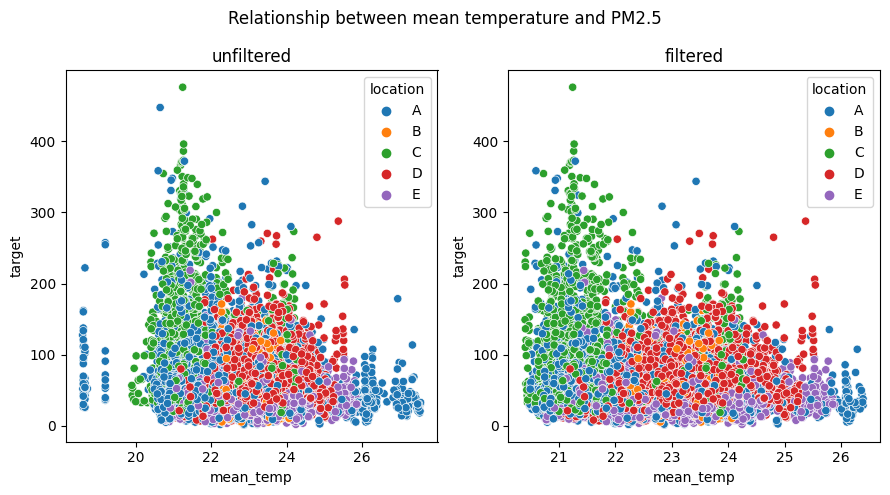

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean temperature and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_temp', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_temp', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

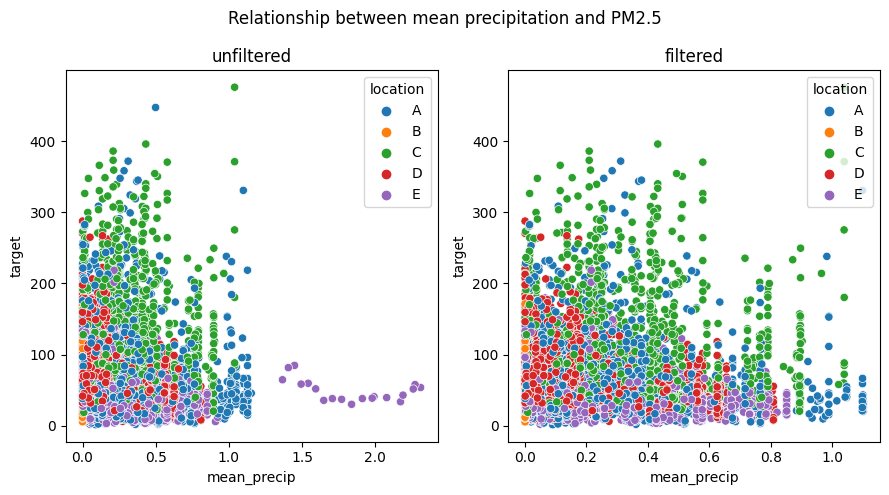

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean precipitation and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_precip', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_precip', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

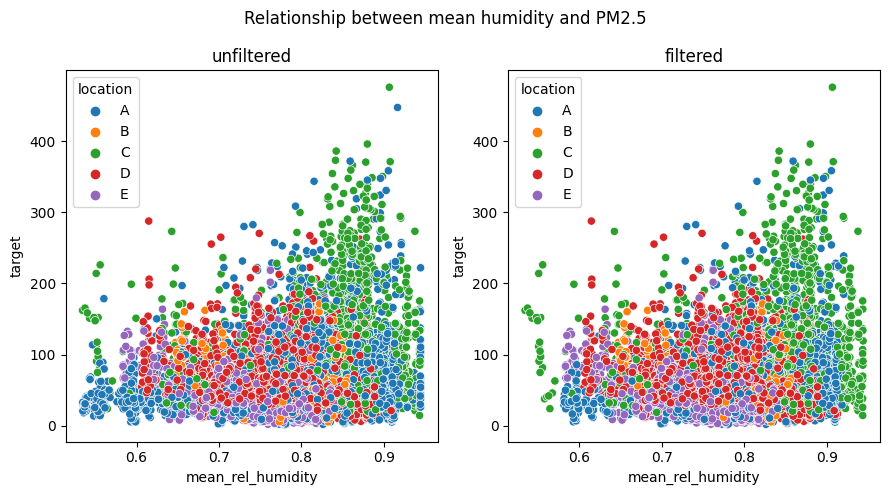

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean humidity and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_rel_humidity', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_rel_humidity', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

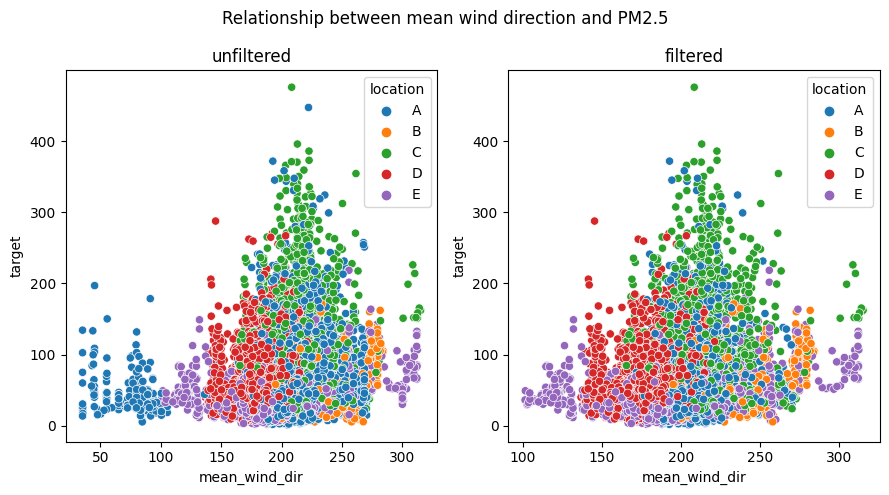

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean wind direction and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_wind_dir', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_wind_dir', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

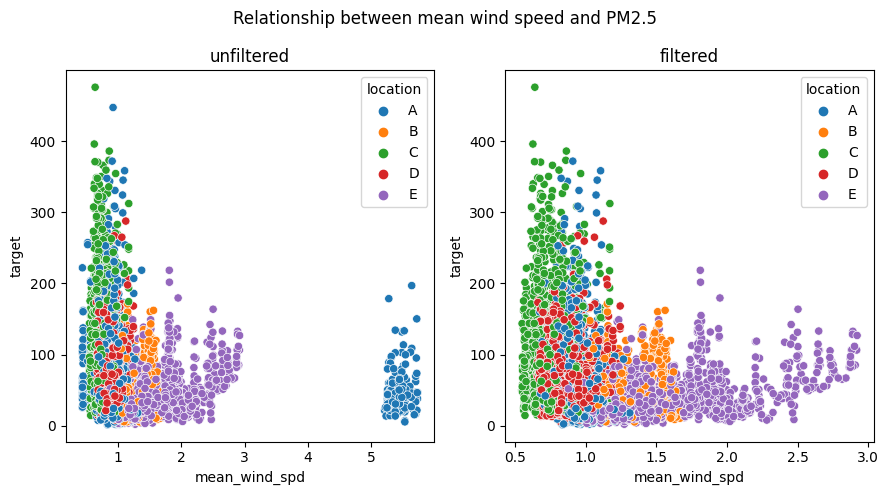

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean wind speed and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_wind_spd', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_wind_spd', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

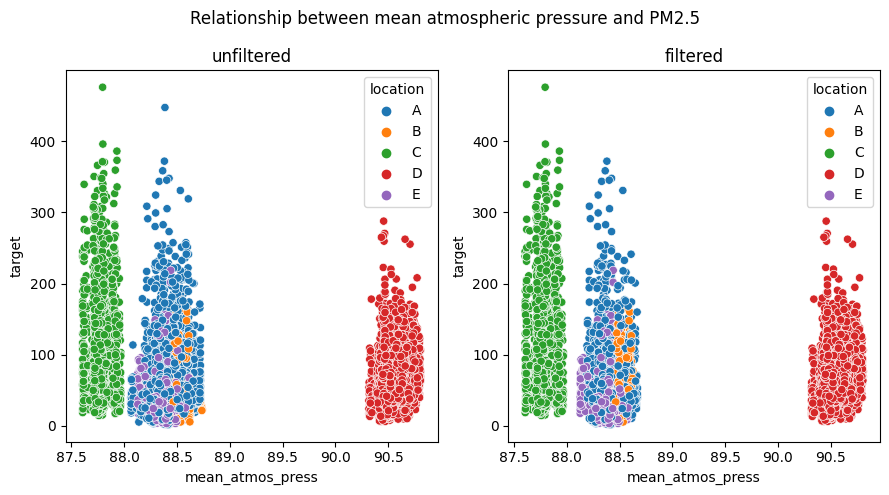

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
plt.suptitle('Relationship between mean atmospheric pressure and PM2.5')

plot1 = sns.scatterplot(data=df_condensed, x='mean_atmos_press', y='target', hue='location', ax=ax1, hue_order=['A', 'B', 'C', 'D', 'E'])
plot1.set_title('unfiltered')

plot2 = sns.scatterplot(data=df_filtered, x='mean_atmos_press', y='target', hue='location', ax=ax2, hue_order=['A', 'B', 'C', 'D', 'E'])
plot2.set_title('filtered')

plt.tight_layout()

### Calculate the basemodel
We compute a baseline model, predicting the target using the mean values of the different features.

In [41]:
# import libraries and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [42]:
# get target and features
X = df_condensed[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']]
y = df_condensed.target

print(X.shape)
print(y.shape)

(15539, 7)
(15539,)


In [43]:
# perform train test split, stratified by location in order to ensure that locations are balanced between training and test set
rseed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=X['location'], random_state=rseed)

print(X_train.shape)
print(X_test.shape)

(10877, 7)
(4662, 7)


In [44]:
# scale features using z-transformation
scaler = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled = scaler.fit_transform(X_train.drop('location', axis=1))
# aply transform to test data
X_test_scaled = scaler.transform(X_test.drop('location', axis=1))

In [45]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(10877, 6)
(4662, 6)


In [46]:
# check if transformation worked

# calculate mean
print('Means')
for i in range(X_train_scaled.shape[1]):
    print(X_train_scaled[:, i].mean().round(2))

print('\nStandard deviations:')
# calculate standard deviation
for i in range(X_train_scaled.shape[1]):
    print(X_train_scaled[:, i].std().round(2))

Means
-0.0
-0.0
-0.0
0.0
0.0
-0.0

Standard deviations:
1.0
1.0
1.0
1.0
1.0
1.0


In [47]:
# train the model
linreg = LinearRegression()

linreg.fit(X_train_scaled, y_train)

LinearRegression()

In [48]:
# get beta coefficients
linreg.coef_

array([-10.67902745,  -1.91655827,  -5.70737807,   2.60187795,
        -3.92071631,  -0.77551937])

In [49]:
# predict new cases
y_pred = linreg.predict(X_test_scaled)

# show first 10 predictions
y_pred[:10]

array([51.41224525, 51.75885997, 55.80861126, 69.80685323, 70.58523159,
       55.79640633, 45.14802649, 62.51733456, 54.11629744, 67.32906964])

In [50]:
# evaluate model accurray

rmse_linreg = mean_squared_error(y_test, y_pred, squared=False)
r2_linreg = r2_score(y_test, y_pred)

print(f'RMSE on testset: {round(rmse_linreg,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg,2)}')

RMSE on testset: 40.76
Coefficient of determination on testset: 0.05


### Calculate baseline model only for location B 
We re-perform our linear regression only using sensor data for location B, because the data for this location seem to be most representative of the whole data, without risking our model training being confounded by location-specific data due to the hierarchical data structure.

In [51]:
# extract data only for location B
df_locB = df_condensed[df_condensed.location == 'B']
df_locB.head()

location     target  percent_nan_temp  percent_nan_precip  \
ID                                                                         
ID_train_10004        B  25.580541         76.859504           76.859504   
ID_train_10044        B  63.030385          0.000000            0.000000   
ID_train_10076        B  27.240250          1.652893            1.652893   
ID_train_1008         B  39.807949          0.000000            0.000000   
ID_train_10111        B   8.681000          0.000000            0.000000   

                percent_nan_rel_humidity  percent_nan_wind_dir  \
ID                                                               
ID_train_10004                 76.859504             78.512397   
ID_train_10044                  0.000000              0.000000   
ID_train_10076                  1.652893             11.570248   
ID_train_1008                   0.000000              0.000000   
ID_train_10111                  0.000000              0.000000   

                percent_nan_wind_spd  percent_nan_atmos_press   max_temp  \
ID                                                                         
ID_train_10004             78.512397                76.859504  26.300000   
ID_train_10044              0.000000                 0.000000  27.150000   
ID_train_10076             11.570248                 1.652893  26.641667   
ID_train_1008               0.000000                 0.000000  27.150000   
ID_train_10111              0.000000                 0.000000  29.158333   

                 min_temp  ...  var_wind_spd  median_wind_spd  ptp_wind_spd  \
ID                         ...                                                
ID_train_10004  19.016667  ...      0.361827         0.900417      1.938333   
ID_train_10044  19.481818  ...      0.643189         1.260000      3.737500   
ID_train_10076  18.958333  ...      0.680961         1.525833      3.101667   
ID_train_1008   19.790909  ...      0.754980         1.295833      3.737500   
ID_train_10111  19.300000  ...      0.644401         1.139167      3.240000   

                max_atmos_press  min_atmos_press  mean_atmos_press  \
ID                                                                   
ID_train_10004        89.031667        88.499167         88.728720   
ID_train_10044        88.850000        88.253636         88.537031   
ID_train_10076        88.915833        88.182500         88.498130   
ID_train_1008         88.850000        88.253636         88.534539   
ID_train_10111        88.720000        88.195000         88.472782   

                std_atmos_press  var_atmos_press  median_atmos_press  \
ID                                                                     
ID_train_10004         0.133882         0.017924           88.732500   
ID_train_10044         0.120693         0.014567           88.531667   
ID_train_10076         0.137447         0.018892           88.505000   
ID_train_1008          0.125287         0.015697           88.531667   
ID_train_10111         0.123768         0.015319           88.482500   

                ptp_atmos_press  
ID                               
ID_train_10004         0.532500  
ID_train_10044         0.596364  
ID_train_10076         0.733333  
ID_train_1008          0.596364  
ID_train_10111         0.525000  

[5 rows x 50 columns]

In [52]:
df_locB.shape

(767, 50)

In [53]:
# get target and features
X_locB = df_locB[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']]
y_locB = df_locB.target

In [54]:
# perform train test split, stratification not needed anymore
rseed = 42

X_train_locB, X_test_locB, y_train_locB, y_test_locB = train_test_split(X_locB, y_locB, test_size=0.3, random_state=rseed)

print(X_train_locB.shape)
print(X_test_locB.shape)

(536, 7)
(231, 7)


In [55]:
# scale features using z-transformation
scaler_locB = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled_locB = scaler.fit_transform(X_train_locB.drop('location', axis=1))
# aply transform to test data
X_test_scaled_locB = scaler.transform(X_test_locB.drop('location', axis=1))

In [56]:
# train the model
linreg_locB = LinearRegression()

linreg_locB.fit(X_train_scaled_locB, y_train_locB)

LinearRegression()

In [57]:
# get beta coefficients
linreg_locB.coef_

array([ 3.01116388,  0.        , -5.99674943,  7.16157397,  3.06042005,
        9.14629549])

In [58]:
# predict new cases
y_pred_locB = linreg.predict(X_test_scaled_locB)

# show first 10 predictions
y_pred_locB[:10]

array([48.1545799 , 32.28048986, 47.71858539, 55.21869194, 48.4550624 ,
       62.27411238, 36.11721568, 81.27902047, 60.08675064, 61.4589005 ])

In [59]:
# evaluate model accurray

rmse_linreg_locB = mean_squared_error(y_test_locB, y_pred_locB, squared=False)
r2_linreg_locB = r2_score(y_test_locB, y_pred_locB)

print(f'RMSE on testset: {round(rmse_linreg_locB,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg_locB,2)}')

RMSE on testset: 34.5
Coefficient of determination on testset: -0.12


### Calculate baseline model with filtered data

In [60]:
# get target and features
X_filtered = df_filtered[['location', 'mean_temp', 'mean_precip', 'mean_rel_humidity', 'mean_wind_dir', 'mean_wind_spd', 'mean_atmos_press']]
y_filtered = df_filtered.target

In [61]:
# perform train test split, stratify according to sensor location
rseed = 42

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered, y_filtered, test_size=0.3, 
                                            stratify=X_filtered['location'], random_state=rseed)

print(X_train_f.shape)
print(X_test_f.shape)

(9465, 7)
(4057, 7)


In [62]:
# scale features using z-transformation
scaler_f = StandardScaler()

# fit_transform training data, drop location column since it will not be used for prediction
X_train_scaled_f = scaler.fit_transform(X_train_f.drop('location', axis=1))
# aply transform to test data
X_test_scaled_f = scaler.transform(X_test_f.drop('location', axis=1))

In [63]:
# train the model
linreg_f = LinearRegression()

linreg_f.fit(X_train_scaled_f, y_train_f)

LinearRegression()

In [64]:
# get beta coefficients
linreg_f.coef_

array([ -9.72550519,  -2.411294  ,  -7.76123989,   6.23770086,
       -11.39893699,  -1.73347445])

In [65]:
# predict new cases
y_pred_f = linreg.predict(X_test_scaled_f)

# show first 10 predictions
y_pred_f[:10]

array([62.2645611 , 64.15323409, 38.62053903, 65.20747464, 62.99181695,
       59.64621362, 63.6942073 , 51.60595637, 43.93966031, 57.63963572])

In [66]:
# evaluate model accurray

rmse_linreg_f = mean_squared_error(y_test_f, y_pred_f, squared=False)
r2_linreg_f = r2_score(y_test_f, y_pred_f)

print(f'RMSE on testset: {round(rmse_linreg_f,2)}')
print(f'Coefficient of determination on testset: {round(r2_linreg_f,2)}')

RMSE on testset: 41.11
Coefficient of determination on testset: 0.09


### Residual plot for baseline model trained on filtered data

In [67]:
# calculate residuals
residual = y_test_f - y_pred_f

# compute mean of residuals
np.mean(residual)

0.1457097199698662

Thus, on average, our baseline model rather seems to underestimate the air pollution, as indicated by an average residual error > 0.

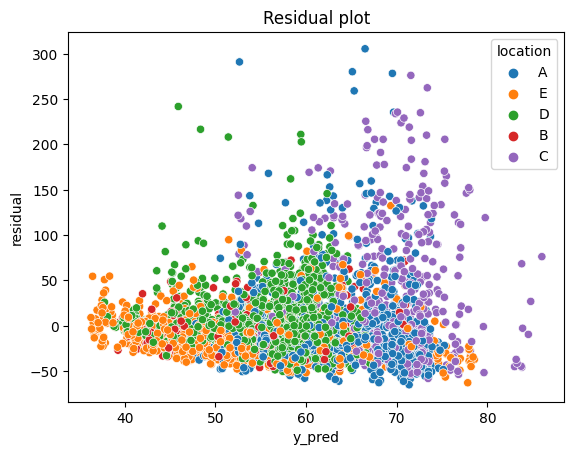

In [68]:
sns.scatterplot(x=y_pred_f, y=residual, hue=X_test_f['location'])
plt.xlabel('y_pred')
plt.ylabel('residual')
plt.title('Residual plot');

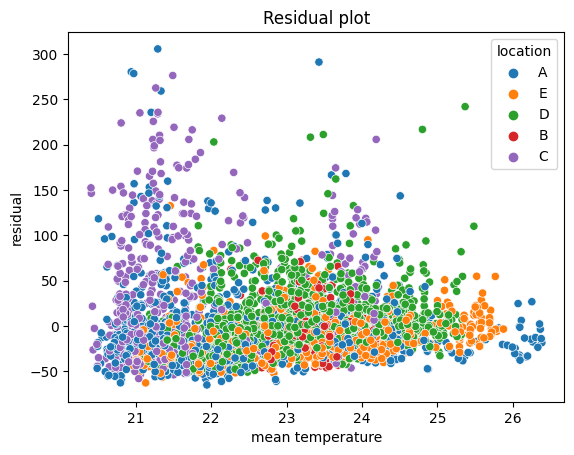

In [69]:
sns.scatterplot(x=X_test_f.mean_temp, y=residual, hue=X_test_f['location'])
plt.xlabel('mean temperature')
plt.ylabel('residual')
plt.title('Residual plot');

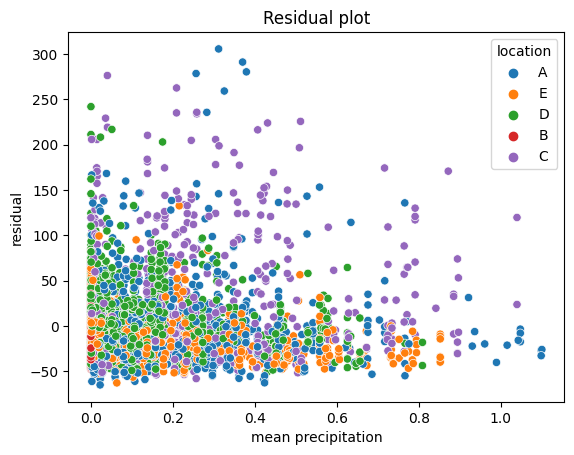

In [70]:
sns.scatterplot(x=X_test_f.mean_precip, y=residual, hue=X_test_f['location'])
plt.xlabel('mean precipitation')
plt.ylabel('residual')
plt.title('Residual plot');

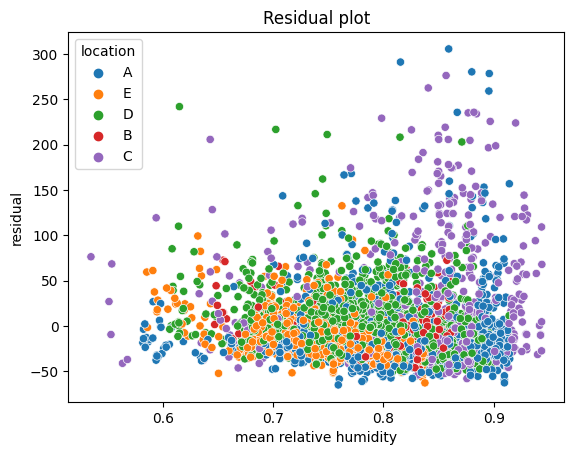

In [71]:
sns.scatterplot(x=X_test_f.mean_rel_humidity, y=residual, hue=X_test_f['location'])
plt.xlabel('mean relative humidity')
plt.ylabel('residual')
plt.title('Residual plot');

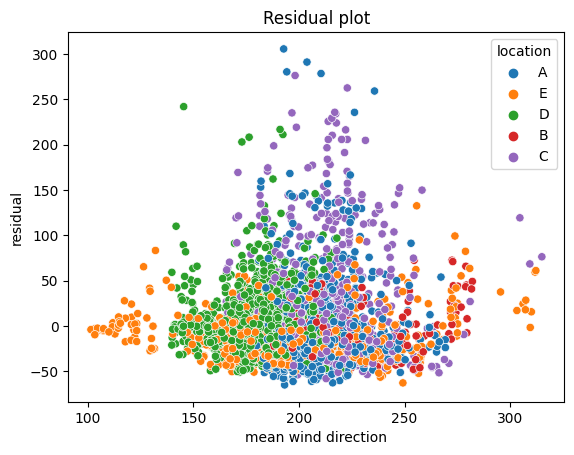

In [72]:
sns.scatterplot(x=X_test_f.mean_wind_dir, y=residual, hue=X_test_f['location'])
plt.xlabel('mean wind direction')
plt.ylabel('residual')
plt.title('Residual plot');

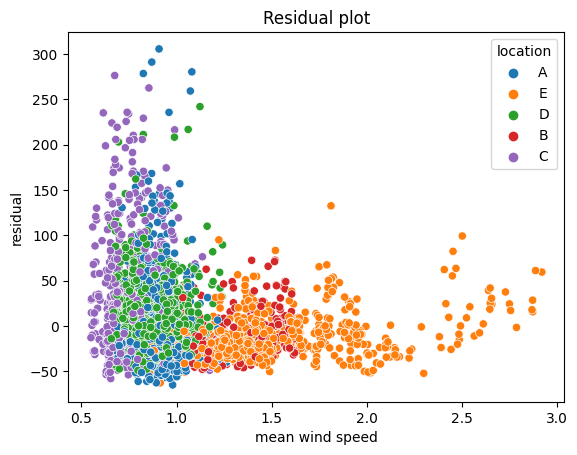

In [73]:
sns.scatterplot(x=X_test_f.mean_wind_spd, y=residual, hue=X_test_f['location'])
plt.xlabel('mean wind speed')
plt.ylabel('residual')
plt.title('Residual plot');

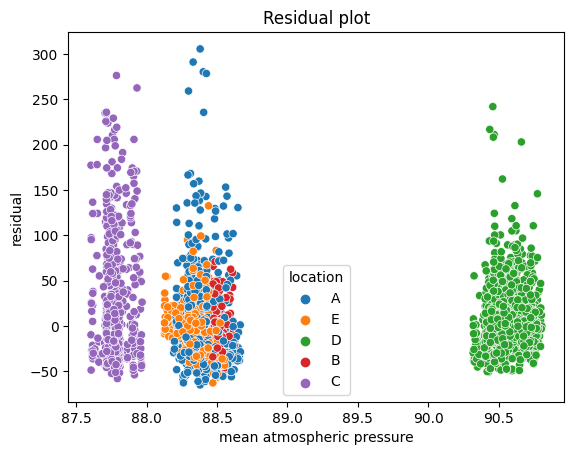

In [74]:
sns.scatterplot(x=X_test_f.mean_atmos_press, y=residual, hue=X_test_f['location'])
plt.xlabel('mean atmospheric pressure')
plt.ylabel('residual')
plt.title('Residual plot');

## Multilevel Analysis

In [80]:
import statsmodels.api as sm

import statsmodels.formula.api as smf

X = X_train_f.drop('location', axis=1)
grp = X_train_f['location']
y = y_train_f

md = sm.MixedLM(y_train_f,X,grp)

mdf = md.fit()

y_pred = md.predict(mdf.fe_params, exog=X_test_f.drop('location', axis=1))

print(mdf.summary())

print('R^2:', round(r2_score(y_test_f, y_pred), 4))
print('RMSE:', round(mean_squared_error(y_test_f, y_pred, squared=False),2))

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target     
No. Observations:    9465      Method:               REML       
No. Groups:          5         Scale:                1490.3360  
Min. group size:     470       Log-Likelihood:       -48019.3727
Max. group size:     3493      Converged:            Yes        
Mean group size:     1893.0                                     
----------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------
mean_temp          -4.735    0.622 -7.612 0.000   -5.954  -3.515
mean_precip        -8.976    2.610 -3.439 0.001  -14.091  -3.860
mean_rel_humidity -76.775   12.331 -6.226 0.000 -100.942 -52.607
mean_wind_dir       0.207    0.020 10.589 0.000    0.169   0.246
mean_wind_spd      -3.781    2.301 -1.643 0.100   -8.290   0.729
mean_atmos_press    2.178    0.300  7.2